In [1]:
import glob
import json
import gzip
import dill as pickle
import pandas as pd

In [2]:
#import sys
#import os
# Dynamically get the path of the current directory
#current_dir = os.getcwd()

# Assuming the package is one level up
#local_package_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add this path to sys.path
#sys.path.insert(0, local_package_dir)

# Now you can import your local package
from truthnet.util import validate
from truthnet.util import calculate_response_parallel

In [3]:
def getresveritas(row):
    with open('../../veritas-experiment2/'+row.jsonpath, 'r') as file:
        data = json.load(file)
    return data[0]['veritas']
def getreskappa(row):
    with open('../../veritas-experiment2/'+row.jsonpath, 'r') as file:
        data = json.load(file)
    return data[0]['lower_threshold']
def getresmu(row):
    with open('../../veritas-experiment2/'+row.jsonpath, 'r') as file:
        data = json.load(file)
    return data[0]['score']
def getres(row):
    with open('../../veritas-experiment2/'+row.jsonpath, 'r') as file:
        data = json.load(file)
    return data[0]['responses']
def getsex(row):
    return row.Sex=='Male'
def getethnicity(row):
    if row['Ethnicity simplified'] == 'White':
        return 0
    if row['Ethnicity simplified'] == 'Black':
        return 1
    if row['Ethnicity simplified'] == 'Asian':
        return 2
    if row['Ethnicity simplified'] == 'Mixed':
        return 3
    return 4

def getpklresp(df):
    A=[{k:v} for k,v in ddf['response'].to_dict().items()]
    with gzip.open('../../response_jsons/experiment2alldata-json.pkl.gz','wb') as file:
        pickle.dump(A,file)

filetimes=pd.read_csv('../../veritas-experiment2/filetimes.csv',names=['sz','creation','jsonpath'])
filetimes.creation = pd.to_datetime(filetimes.creation)
filetimes=filetimes.set_index('creation')
#filetimes=filetimes.sort_index().tail(100)
filetimes=filetimes.reset_index()

In [4]:
de1=pd.read_csv('../../veritas-experiment/prolific_export_659b858e59d89ff7f7340157.csv')
de1=de1[de1.Status=='APPROVED']

de2=pd.read_csv('../../veritas-experiment/prolific_export_659b69ff0a427599bec1d811.csv')
de2=de2[de2.Status=='APPROVED']

de=pd.concat([de1,de2]).assign(batch=0)

In [5]:
demog=pd.read_csv('../../veritas-experiment2/prolific_export_65a96448a2efd0a811b1db33-exp2.csv')
demog=demog[demog.Status!='RETURNED']
demog=demog.assign(batch=1)
demog=pd.concat([demog, de])
demog['Completed at']=pd.to_datetime(demog['Completed at'])
demog=demog.set_index('Completed at')
demog=demog.sort_index().reset_index()

demog=demog.join(filetimes)

ddf=demog[['Participant id','Time taken','Age', 'Sex', 'Ethnicity simplified','jsonpath',
           'Country of birth', 'Country of residence', 'Nationality', 'Language',]].set_index('Participant id')

ddf['veritas']=ddf.apply(getresveritas,axis=1)
ddf['kappa']=ddf.apply(getreskappa,axis=1)
ddf['score']=ddf.apply(getresmu,axis=1)
ddf['sex']=ddf.apply(getsex,axis=1)
ddf['ethnicity']=ddf.apply(getethnicity,axis=1)
ddf['Age']=ddf.Age.astype(float)
ddf['response'] = ddf.apply(getres,axis=1)
getpklresp(ddf)

In [6]:
#calculate_response_parallel('../../response_jsons/experiment2alldata-json.pkl.gz','../../veritas_models/veritas_002.pkl.gz','./res_exp2_model2.csv')

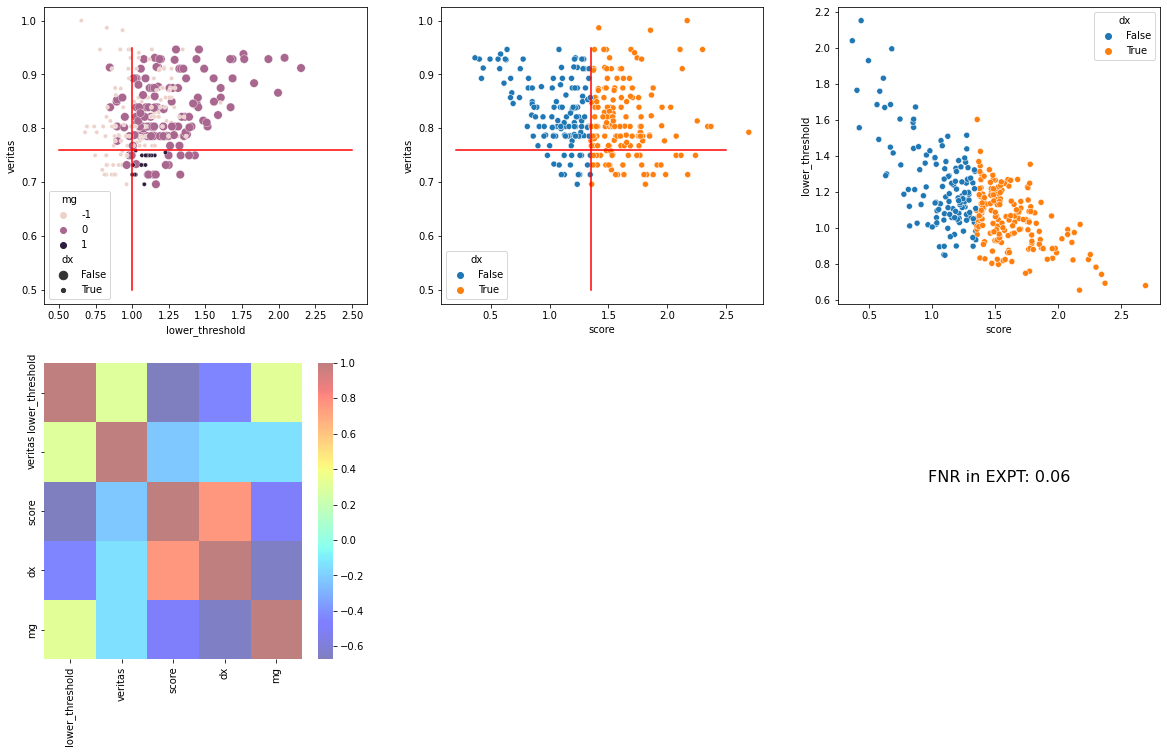

In [7]:
import pandas as pd
resf=pd.read_csv('../../data/res_expbatch012_model2.csv',index_col=0).T
resf.columns=['lower_threshold','veritas','score']
expd2,expf2=validate(resf,C0=1,C1=0.76,C2=1.35,DX=False,score=True,
         outfile='exptvalid2.png',
         validation_type='fnrexpt')

In [8]:
expd2

{'fnr': 0.05806451612903226}

In [9]:
1-expd2['fnr']

0.9419354838709677

In [123]:
resfva=pd.read_csv('../../data/res_R20_model2.csv',index_col=0).T
resfva.columns=['lower_threshold','veritas','score']
resfva['dx'] = [int(x[-1]) for x in resfva.index.values]
d2,wf2,zt=validate(resfva,C0=1,C1=0.76,C2=1.35,DX=True,score=True,verbose=False,
         outfile='ptsdvalid.png',plots=False,
         validation_type='withdx')

In [125]:
1-d2['mratio']

0.7906976744186046

In [50]:
from tqdm import tqdm
import numpy as np

prev=0.3
C0=1
C1=.76
C2=1.35
R={}

for C0 in tqdm(np.arange(.85,1.15,.05),'C0'):
    for C2 in np.arange(1.15,1.6,.05):
        for prev in np.arange(.15,.31,.05):
            expd2,expf2=validate(resf,C0=C0,C1=C1,C2=C2,DX=False,score=True,
                     outfile='exptvalid2.png',plots=False,
                     validation_type='fnrexpt')
            d2,_,_=validate(resfva,C0=C0,C1=C1,C2=C2,DX=True,score=True,verbose=False,
                     outfile='ptsdvalid.png',plots=False,
                     validation_type='withdx')
            #ppv=1-d2['mratio']
            fpr=d2['mratio']
            tpr=1-expd2['fnr']
            #fpr=tpr * (1/ppv -1)/(1/prev -1)
            R[(C0,C1,C2,prev)] = {'fpr':fpr,'tpr':tpr}
rf=pd.DataFrame(R).T.reset_index(drop=True)

C0: 100%|█████████████████████████████████████████| 6/6 [09:08<00:00, 91.46s/it]


In [128]:
rf=pd.DataFrame(R).T.reset_index().rename(columns={'level_0':'C0','level_1':'C1','level_2':'C2','level_3':'prev'})
rf.prev=rf.prev.astype(float)
rf[(rf.C0==.9) & (rf.C2==1.35)]
#rf1=rf[rf.prev==.2]
#rf1

,C0,C1,C2,prev,fpr,tpr
56,0.9,0.76,1.35,0.15,0.116279,0.916129
57,0.9,0.76,1.35,0.20,0.116279,0.916129
58,0.9,0.76,1.35,0.25,0.116279,0.916129
59,0.9,0.76,1.35,0.30,0.116279,0.916129


prev:  25%|█████████▊                             | 1/4 [00:02<00:07,  2.37s/it]

0.15 (0.9707467741935485, 0.9812719850515674, 0.9602218524141485)


prev:  50%|███████████████████▌                   | 2/4 [00:04<00:04,  2.31s/it]

0.2 (0.9707467741935485, 0.9812719850515674, 0.9602218524141485)


prev:  75%|█████████████████████████████▎         | 3/4 [00:06<00:02,  2.33s/it]

0.25 (0.9707467741935485, 0.9812719850515674, 0.9602218524141485)


prev: 100%|███████████████████████████████████████| 4/4 [00:09<00:00,  2.30s/it]

0.30000000000000004 (0.9707467741935485, 0.9812719850515674, 0.9602218524141485)


,tpr,ppv,acc,npv,LR+,LR-,prevalence
fpr,,,,,,,
0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.15
0.047,0.958468,0.781155,0.953412,0.992366,20.318078,0.043593,0.15
0.048,0.958871,0.778060,0.952648,0.992433,20.037769,0.043206,0.15
0.049,0.959274,0.774965,0.951885,0.992501,19.757460,0.042818,0.15
0.050,0.959677,0.771869,0.951122,0.992568,19.477151,0.042431,0.15
...,...,...,...,...,...,...,...
0.996,0.999983,0.301842,0.302792,0.998229,1.018009,0.004141,0.30
0.997,0.999988,0.301381,0.302094,0.998229,1.013507,0.004141,0.30
0.998,0.999992,0.300921,0.301396,0.998229,1.009004,0.004141,0.30


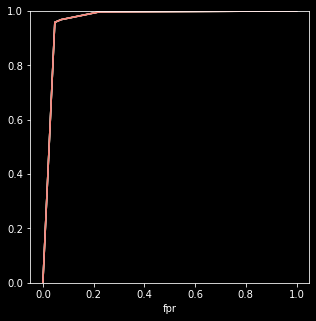

In [116]:
from zedstat import zedstat
import pylab as plt
plt.figure(figsize=[5,5])
plt.style.use('dark_background')
ax=plt.gca()
Zf=[]
XF=[]
for prev in tqdm(np.arange(.15,.31,.05),'prev'):
    ztm=zedstat.processRoc(df=rf[rf.prev==prev],
                          order=3, 
                          total_samples=86+310,
                          positive_samples=310,
                          alpha=0.01,
                          prevalence=prev)
    ztm.smooth(STEP=0.001)
    ztm.allmeasures(interpolate=False)
    ztm.usample(precision=3)
    Z=ztm.get().dropna()
    Z.loc[0,:]=0
    Z=Z.sort_index()
    ax=Z.tpr.plot(ax=ax)
    ax.set_ylim(0,1)
    print(prev,ztm.auc())
    Zf=Zf+[Z.assign(prevalence=prev)]

    ZZ=ztm.get().join(ztm.usample(ztm.df_lim['U']),rsuffix='U').join(ztm.usample(ztm.df_lim['L']),lsuffix='L').dropna()

    #ZZ=ZZ[(ZZ.ppv>0.78) & (ZZ.index>0.047)]
    
    ZL=ZZ[['tprL', 'ppvL', 'accL', 'npvL', 'LR+L', 'LR-L']]
    Z0=ZZ[['tpr', 'ppv', 'acc', 'npv', 'LR+', 'LR-']]
    ZU=ZZ[['tprU', 'ppvU', 'accU', 'npvU', 'LR+U', 'LR-U']]
    ZU.columns=['tpr', 'ppv', 'acc', 'npv', 'LR+', 'LR-']
    ZL.columns=['tpr', 'ppv', 'acc', 'npv', 'LR+', 'LR-']
    from zedstat.textable import tablewithbounds

    xf=tablewithbounds(Z0,ZU,ZL).assign(prevalence=prev)#.to_csv('table.csv')
    xf=xf.join(Z0,rsuffix='_zz')
    #xf=xf[(xf.ppv_zz.values.astype(float)>0.78)]
    XF=XF+[xf]


XF=pd.concat(XF)
Zf=pd.concat(Zf)
display(Zf)

In [117]:
zzf=Zf[Zf.ppv>0.78].sort_values('ppv')
zzf.reset_index().groupby('prevalence').max()

,fpr,tpr,ppv,acc,npv,LR+,LR-
prevalence,,,,,,,
0.15,0.047,0.958468,0.781155,0.953412,0.992366,20.318078,0.043593
0.20,0.068,0.966935,0.834837,0.953709,0.991215,20.318078,0.043593
0.25,0.097,0.973090,0.870760,0.954006,0.990424,20.318078,0.043593
0.30,0.127,0.978820,0.896489,0.954304,0.990268,20.318078,0.043593


In [118]:
XF[XF.ppv_zz>0.77].prevalence.value_counts()

0.30    76
0.25    48
0.20    24
0.15     3
Name: prevalence, dtype: int64

In [119]:
xf=XF[XF.ppv_zz>0.77]
xf=xf.reset_index().groupby('prevalence').max()[['fpr','tpr','ppv','npv','acc','LR+','LR-']]

In [120]:
xf=xf.reset_index().rename(columns={'tpr':'sensitivity','prevalence':'prev.'})
xf['specificity'] = 1-xf.fpr
xf=xf.reset_index(drop=True).set_index('prev.')
xf=xf[['sensitivity','specificity','ppv','npv','acc','LR+','LR-']]
xf

,sensitivity,specificity,ppv,npv,acc,LR+,LR-
prev.,,,,,,,
0.15,$0.930 \pm 0.014$,0.951,$0.777 \pm 0.003$,$0.987 \pm 0.002$,$0.949 \pm 0.002$,$19.77 \pm 0.347$,$0.074 \pm 0.015$
0.20,$0.942 \pm 0.012$,0.930,$0.831 \pm 0.002$,$0.984 \pm 0.003$,$0.948 \pm 0.003$,$19.77 \pm 0.347$,$0.074 \pm 0.015$
0.25,$0.948 \pm 0.012$,0.906,$0.868 \pm 0.002$,$0.981 \pm 0.004$,$0.947 \pm 0.003$,$19.77 \pm 0.347$,$0.074 \pm 0.015$
0.30,$0.956 \pm 0.010$,0.878,$0.894 \pm 0.001$,$0.979 \pm 0.004$,$0.945 \pm 0.004$,$9.988 \pm 0.890$,$0.074 \pm 0.015$


In [121]:
from zedstat.textable import textable
textable(xf,tabname='../tex/overleaf/Figures/tabperf.tex',FORMAT='%1.2f',
         INDEX=True,LNTERM='\\\\\n',TABFORMAT='L{.3in}|L{.7in}|L{.55in}|L{.7in}|L{.7in}|L{.7in}|L{.7in}|L{.7in}')     

In [114]:
! cat ../tex/overleaf/Figures/tabperf.tex

\begin{tabular}{L{.3in}|L{.7in}|L{.55in}|L{.7in}|L{.7in}|L{.7in}|L{.7in}|L{.7in}}\hline
prev.&sensitivity&specificity&ppv&npv&acc&LR+&LR-\\
0.15& $0.930  \pm  0.014$ &0.95& $0.777  \pm  0.003$ & $0.987  \pm  0.002$ & $0.949  \pm  0.002$ & $19.77  \pm  0.347$ & $0.074  \pm  0.015$ \\
0.20& $0.942  \pm  0.012$ &0.93& $0.831  \pm  0.002$ & $0.984  \pm  0.003$ & $0.948  \pm  0.003$ & $19.77  \pm  0.347$ & $0.074  \pm  0.015$ \\
0.25& $0.948  \pm  0.012$ &0.91& $0.868  \pm  0.002$ & $0.981  \pm  0.004$ & $0.947  \pm  0.003$ & $19.77  \pm  0.347$ & $0.074  \pm  0.015$ \\
0.30& $0.956  \pm  0.010$ &0.88& $0.894  \pm  0.001$ & $0.979  \pm  0.004$ & $0.945  \pm  0.004$ & $9.988  \pm  0.890$ & $0.074  \pm  0.015$ \\
\hline\end{tabular}
